In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Method used for getting the right path for a model based on the device name and the cv number
'''
root_path: the root path of the project
device: the device name
cv: the cross validation number

Acceptable model types: attend, deepconv, tinyhar
'''


def get_model_path(root_path, device, model_type, cv):
    path = root_path
    parent_path = os.path.join(path, 'data', 'Run_logs', device, 'logs')
    # parent paths has three folders for attend, deepCONV, TinyHAR. Get a list of all folders in the parent path
    folders = os.listdir(parent_path)
    for folder in folders:
        if model_type in folder:
            path = os.path.join(parent_path, folder)
            break
    # path now has the path to the model type folder
    path = os.path.join(path, 'cv_' + str(cv))
    return path


def get_result_for_model(root_path, model_device, test_device, model_type, cv):
    path = get_model_path(root_path, model_device, model_type, cv)
    filename = 'prediction_result_' + model_device + '_' + test_device + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    accuracy = np.sum(preds == trues) / len(preds)
    precision = np.sum((preds == 1) & (trues == 1)) / np.sum(preds == 1)
    recall = np.sum((preds == 1) & (trues == 1)) / np.sum(trues == 1)
    f1 = 2 * np.sum((preds == 1) & (trues == 1)) / (np.sum(preds == 1) + np.sum(trues == 1))

    return accuracy, precision, recall, f1  #, preds, trues

In [3]:
# Method for creating a multi bar graph with x axis and y axis values in the for of a list
'''
x: list of x axis labels
y: list of y axis values
x_label: x axis label
y_label: y axis label
title: title of the graph
width: width of the graph
height: height of the graph
bar_width: width of each bar
'''


def generate_multi_bar_graph(data_frame, x_label, y_label, title, width, height, bar_width, std=False):
    # set the width of the bars
    bar_width = bar_width
    sns.barplot(data_frame, x=x_label, y=y_label, palette='dark', errorbar='sd' if std else None)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(width, height)
    plt.show()


def generate_mean_graph_for_model_type(root_path, model_device, test_devices, model_type):
    # get the result for the model
    # Get the average CV results for model_device with all th devices in test_devices
    model_results = [[] for i in range(len(test_devices))]
    for device in test_devices:
        for i in range(8):
            model_results[test_devices.index(device)].append(
                get_result_for_model(root_path, model_device, device, model_type, i))
    # get the average of the results
    mean_f1_scores = []
    for i in range(len(test_devices)):
        mean_f1_scores.append(np.mean(model_results[i][3], axis=0))

    # get the standard deviation of the results
    std_f1_scores = []
    for i in range(len(test_devices)):
        std_f1_scores.append(np.std(model_results[i][3], axis=0))

    # get the data frame
    data_frame = pd.DataFrame({'Device': test_devices, 'F1 Score': mean_f1_scores, 'Standard Deviation': std_f1_scores})
    # generate the graph
    generate_multi_bar_graph(data_frame, 'Device', 'F1 Score',
                             'Mean F1 Scores for Model trained with ' + model_device + ' and model type ' + model_type,
                             10, 5,
                             0.5, std=True)


def generate_mean_graph_for_model_all_type(root_path, model_device, test_devices):
    generate_mean_graph_for_model_type(root_path, model_device, test_devices, 'attend')
    generate_mean_graph_for_model_type(root_path, model_device, test_devices, 'deepconv')
    generate_mean_graph_for_model_type(root_path, model_device, test_devices, 'tinyhar')


def generate_graph_with_std(root_path, model_device, test_devices):
    data = {'Device': [], 'F1 Score': [], 'model_type': []}
    df = pd.DataFrame(data)
    for device in test_devices:
        for i in range(8):
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'attend', i)[3],
                       'model_type': 'attend'}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'deepconv', i)[3],
                       'model_type': 'deepconv'}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_row = {'Device': device,
                       'F1 Score': get_result_for_model(root_path, model_device, device, 'tinyhar', i)[3],
                       'model_type': 'tinyhar'}
            df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    # generate the graph
    g = sns.catplot(x='Device', y='F1 Score', hue='model_type', data=df, kind='bar', palette='dark', errorbar='sd',
                    alpha=.6, height=6, aspect=2).set(title='F1 Score for Model trained with ' + model_device)
    g.despine(left=True)
    g.set_ylabels('F1 Score')
    g.set_xlabels('Device')
    g.set_xticklabels(rotation=45)

    # save the graph in folder mean_graphs in the logs, create folder if not exists
    if not os.path.exists(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs')):
        os.makedirs(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs'))
    # plt.savefig(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs',
    #                          'F1 Score for Model trained with ' + model_device + '.png'))


In [4]:
root_path = os.path.abspath(os.path.join('..', '..'))

In [5]:
# # generate multi bar graph for bluesense RWR1 vs bluesense RWR2 and empatica-right
# # get the result for bluesense RWR1 vs bluesense RWR1
# bs_rwr1_bs_rwr1 = get_result_for_model(root_path, 'bluesense-RWR1', 'bluesense-RWR1', 'attend', 0)
# # get the result for bluesense RWR1 vs bluesense RWR2
# bs_rwr1_bs_rwr2 = get_result_for_model(root_path, 'bluesense-RWR1', 'bluesense-RWR2', 'attend', 0)
# # get the result for bluesense RWR1 vs emaptica-right
# bs_rwr1_emaptica_right = get_result_for_model(root_path, 'bluesense-RWR1', 'empatica-right', 'attend', 0)
#
# print(bs_rwr1_bs_rwr1)
# print(bs_rwr1_bs_rwr2)
# print(bs_rwr1_emaptica_right)

In [6]:
# # Get the average CV results for bluesense-RWR1 vs bluesense-RWR2 and empatica-right
# bs_rwr1_bs_rwr1 = []
# bs_rwr1_bs_rwr2 = []
# bs_rwr1_emaptica_right = []
# for i in range(8):
#     bs_rwr1_bs_rwr1.append(get_result_for_model(root_path, 'bluesense-RWR1', 'bluesense-RWR1', 'attend', i))
#     bs_rwr1_bs_rwr2.append(get_result_for_model(root_path, 'bluesense-RWR1', 'bluesense-RWR2', 'attend', i))
#     bs_rwr1_emaptica_right.append(get_result_for_model(root_path, 'bluesense-RWR1', 'empatica-right', 'attend', i))


In [7]:
# # create a dataframe for the results at index 0, 1, 2, 3
# df = pd.DataFrame({'devices': ['bluesense-RWR1_bluesense-RWR1', 'bluesense-RWR1_bluesense-RWR2', 'bluesense-RWR1_empatica-right'],
#                    'accuracy': [np.mean([x[0] for x in bs_rwr1_bs_rwr1]), np.mean([x[0] for x in bs_rwr1_bs_rwr2]), np.mean([x[0] for x in bs_rwr1_emaptica_right])],
#                    'precision': [np.mean([x[1] for x in bs_rwr1_bs_rwr1]), np.mean([x[1] for x in bs_rwr1_bs_rwr2]), np.mean([x[1] for x in bs_rwr1_emaptica_right])],
#                    'recall': [np.mean([x[2] for x in bs_rwr1_bs_rwr1]), np.mean([x[2] for x in bs_rwr1_bs_rwr2]), np.mean([x[2] for x in bs_rwr1_emaptica_right])],
#                    'f1': [np.mean([x[3] for x in bs_rwr1_bs_rwr1]), np.mean([x[3] for x in bs_rwr1_bs_rwr2]), np.mean([x[3] for x in bs_rwr1_emaptica_right])]})
#
# # generate_multi_bar_graph(df, 'devices', 'accuracy', 'Accuracy for bluesense-RWR1 vs bluesense-RWR2 and empatica-right', 10, 5, 0.5)
# # generate_multi_bar_graph(df, 'devices', 'precision', 'Precision for bluesense-RWR1 vs bluesense-RWR2 and empatica-right', 10, 5, 0.5)
# # generate_multi_bar_graph(df, 'devices', 'recall', 'Recall for bluesense-RWR1 vs bluesense-RWR2 and empatica-right', 10, 5, 0.5)
# generate_multi_bar_graph(df, 'devices', 'f1', 'Mean F1 for bluesense-RWR1 vs bluesense-RWR2 and empatica-right over all participant', 10, 5, 0.5)

In [8]:
# # generate a graph for each CV result for bluesense-RWR1 vs bluesense-RWR2 and empatica-right
# for i in range(8):
#     df = pd.DataFrame({'devices': ['bluesense-RWR1_bluesense-RWR1', 'bluesense-RWR1_bluesense-RWR2', 'bluesense-RWR1_empatica-right'],
#                        'accuracy': [bs_rwr1_bs_rwr1[i][0], bs_rwr1_bs_rwr2[i][0], bs_rwr1_emaptica_right[i][0]],
#                        'precision': [bs_rwr1_bs_rwr1[i][1], bs_rwr1_bs_rwr2[i][1], bs_rwr1_emaptica_right[i][1]],
#                        'recall': [bs_rwr1_bs_rwr1[i][2], bs_rwr1_bs_rwr2[i][2], bs_rwr1_emaptica_right[i][2]],
#                        'f1': [bs_rwr1_bs_rwr1[i][3], bs_rwr1_bs_rwr2[i][3], bs_rwr1_emaptica_right[i][3]]})
#
#     # generate_multi_bar_graph(df, 'devices', 'accuracy', 'Accuracy for bluesense-RWR1 vs bluesense-RWR2 and empatica-right', 10, 5, 0.5)
#     # generate_multi_bar_graph(df, 'devices', 'precision', 'Precision for bluesense-RWR1 vs bluesense-RWR2 and empatica-right', 10, 5, 0.5)
#     # generate_multi_bar_graph(df, 'devices', 'recall', 'Recall for bluesense-RWR1 vs bluesense-RWR2 and empatica-right', 10, 5, 0.5)
#     generate_multi_bar_graph(df, 'devices', 'f1', 'F1 for bluesense-RWR1 vs bluesense-RWR2 and empatica-right for participant ' + str(i), 10, 5, 0.5)

In [9]:
# # Get the average CV results for bluesense-LWR vs bluesense-LUA, empatica-left and maxim-green
# bs_lwr_bs_lwr = []
# bs_lwr_bs_lua = []
# bs_lwr_emaptica_left = []
# bs_lwr_maxim_green = []
# for i in range(8):
#     bs_lwr_bs_lwr.append(get_result_for_model(root_path, 'bluesense-LWR', 'bluesense-LWR', 'attend', i))
#     bs_lwr_bs_lua.append(get_result_for_model(root_path, 'bluesense-LWR', 'bluesense-LUA', 'attend', i))
#     bs_lwr_emaptica_left.append(get_result_for_model(root_path, 'bluesense-LWR', 'empatica-left', 'attend', i))
#     bs_lwr_maxim_green.append(get_result_for_model(root_path, 'bluesense-LWR', 'maxim-green', 'attend', i))


In [10]:
# # create a dataframe for the results at index 0, 1, 2, 3
# df = pd.DataFrame({'devices': ['bluesense-LWR_bluesense-LWR', 'bluesense-LWR_bluesense-LUA', 'bluesense-LWR_empatica-left', 'bluesense-LWR_maxim-green'],
#                    'accuracy': [np.mean([x[0] for x in bs_lwr_bs_lwr]), np.mean([x[0] for x in bs_lwr_bs_lua]), np.mean([x[0] for x in bs_lwr_emaptica_left]), np.mean([x[0] for x in bs_lwr_maxim_green])],
#                    'precision': [np.mean([x[1] for x in bs_lwr_bs_lwr]), np.mean([x[1] for x in bs_lwr_bs_lua]), np.mean([x[1] for x in bs_lwr_emaptica_left]), np.mean([x[1] for x in bs_lwr_maxim_green])],
#                    'recall': [np.mean([x[2] for x in bs_lwr_bs_lwr]), np.mean([x[2] for x in bs_lwr_bs_lua]), np.mean([x[2] for x in bs_lwr_emaptica_left]), np.mean([x[2] for x in bs_lwr_maxim_green])],
#                    'f1': [np.mean([x[3] for x in bs_lwr_bs_lwr]), np.mean([x[3] for x in bs_lwr_bs_lua]), np.mean([x[3] for x in bs_lwr_emaptica_left]), np.mean([x[3] for x in bs_lwr_maxim_green])]})
#
# generate_multi_bar_graph(df, 'devices', 'f1', 'F1 for bluesense-RWR1 vs bluesense-RWR2 and empatica-right for participant ' + str(i), 10, 5, 0.5)

In [11]:
test_devices = ['bluesense-RWR1', 'bluesense-RWR2', 'bluesense-LWR', 'bluesense-LUA', 'bluesense-RUA', 'bluesense-TRS',
                'empatica-left', 'empatica-right', 'maxim-green']

In [12]:
# generate_mean_graph_for_model_all_type(root_path, 'bluesense-RWR1', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'bluesense-RWR2', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'bluesense-LWR', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'bluesense-LUA', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'bluesense-RUA', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'bluesense-TRS', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'empatica-left', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'empatica-right', test_devices)
# generate_mean_graph_for_model_all_type(root_path, 'maxim-green', test_devices)

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

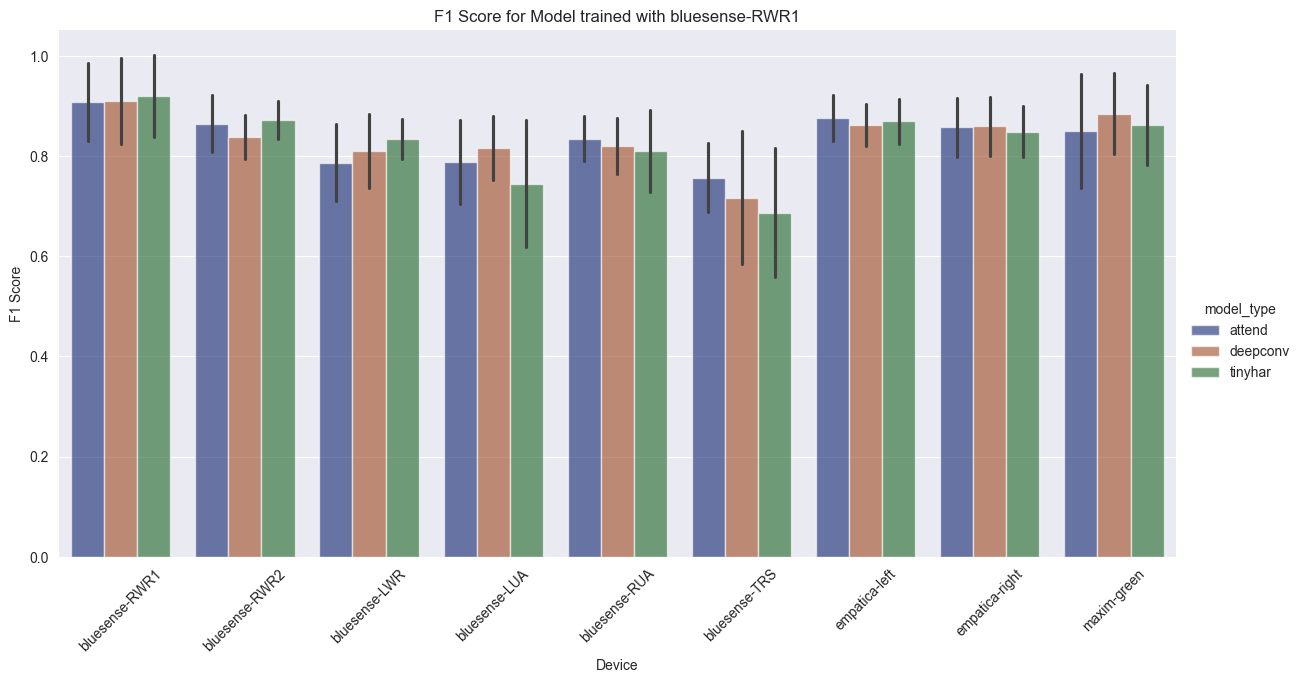

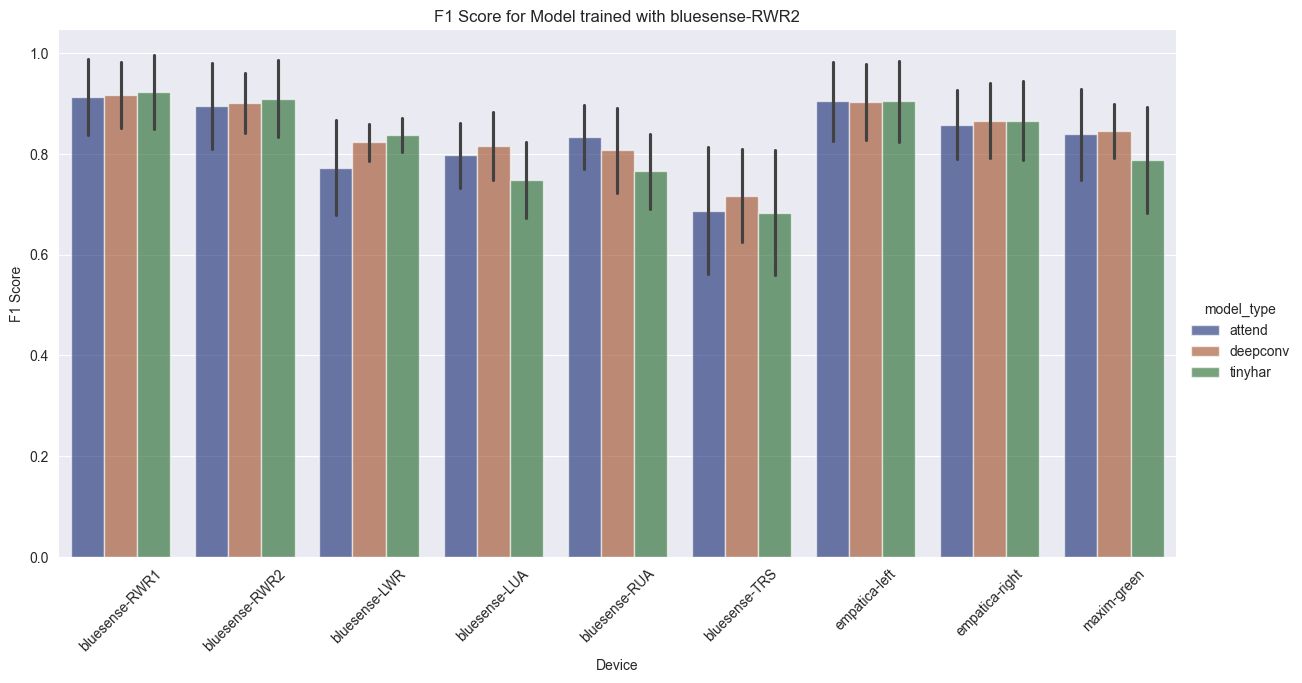

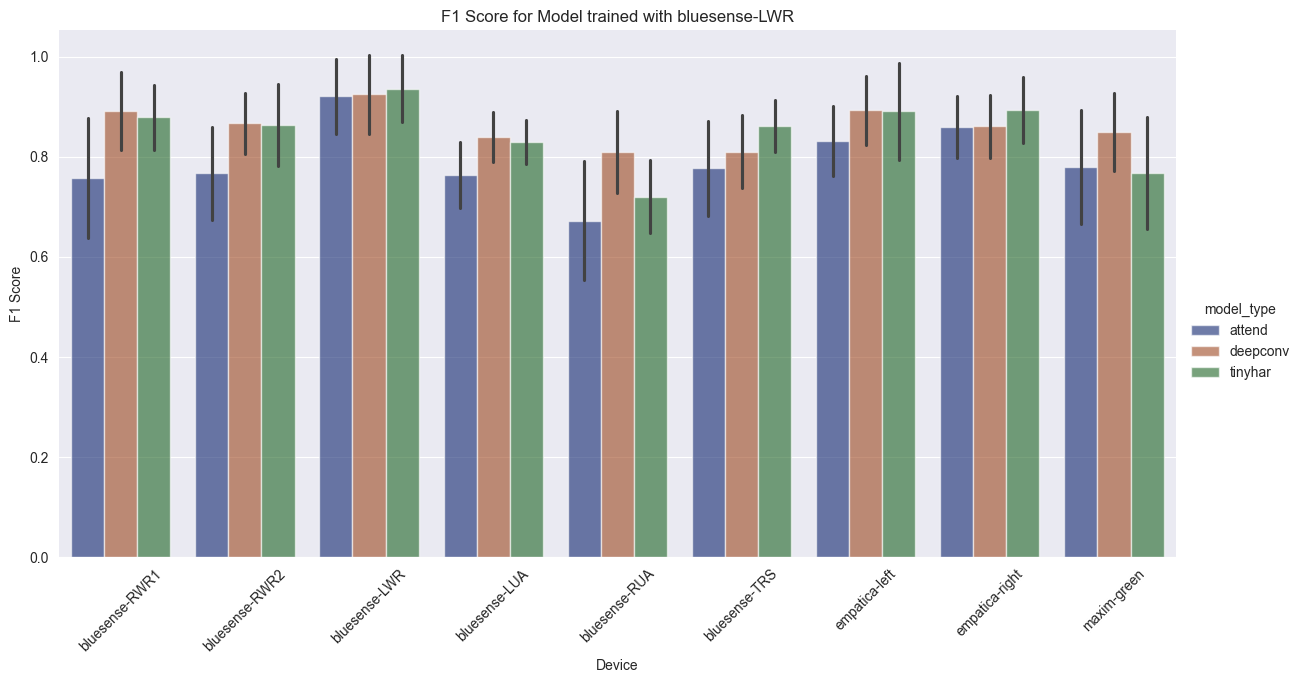

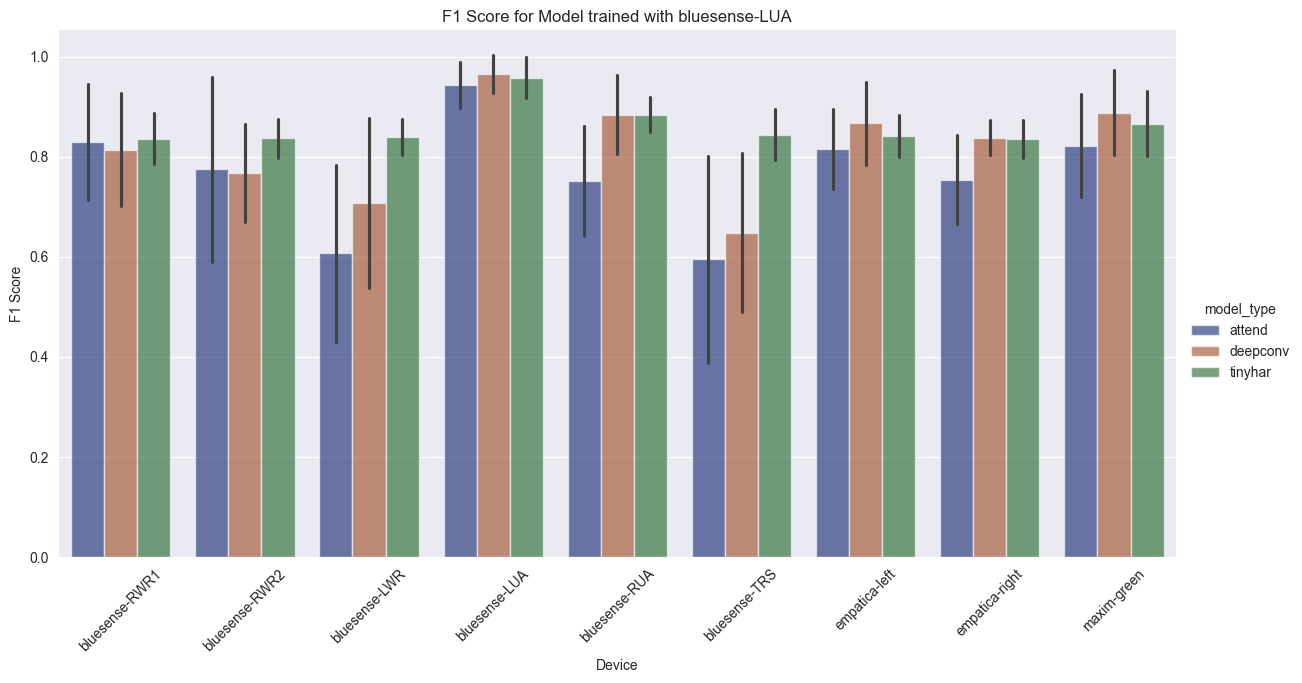

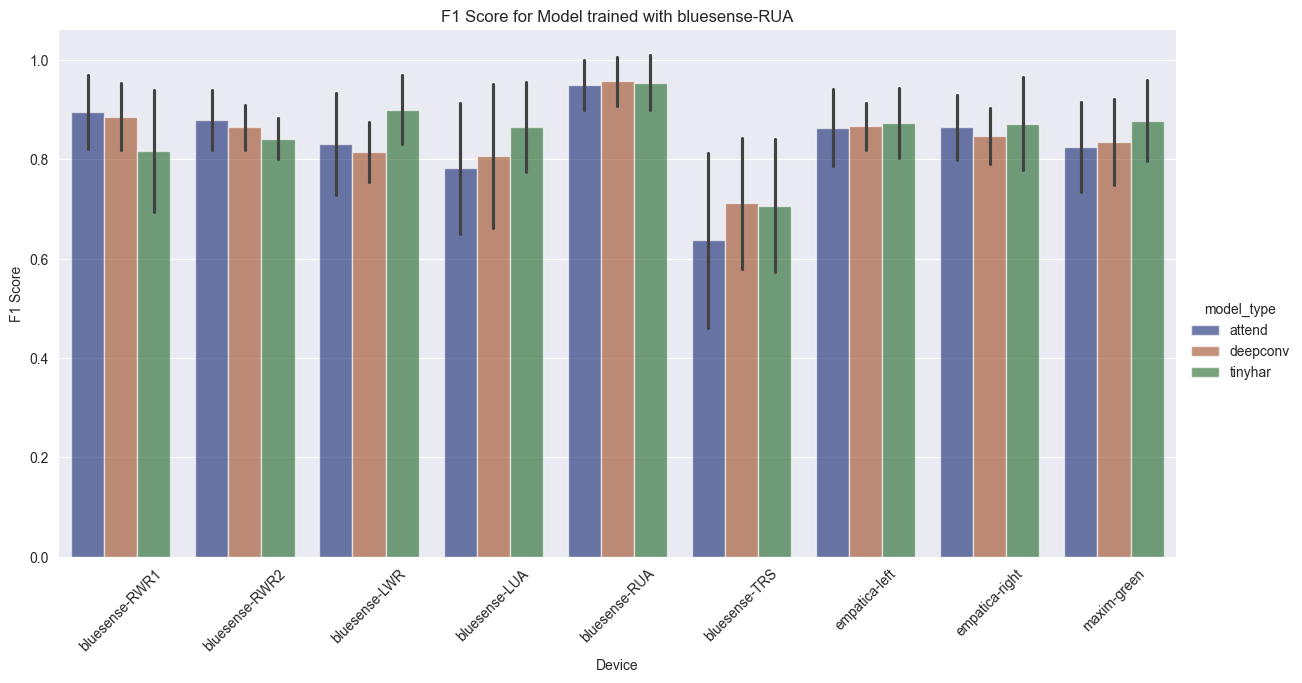

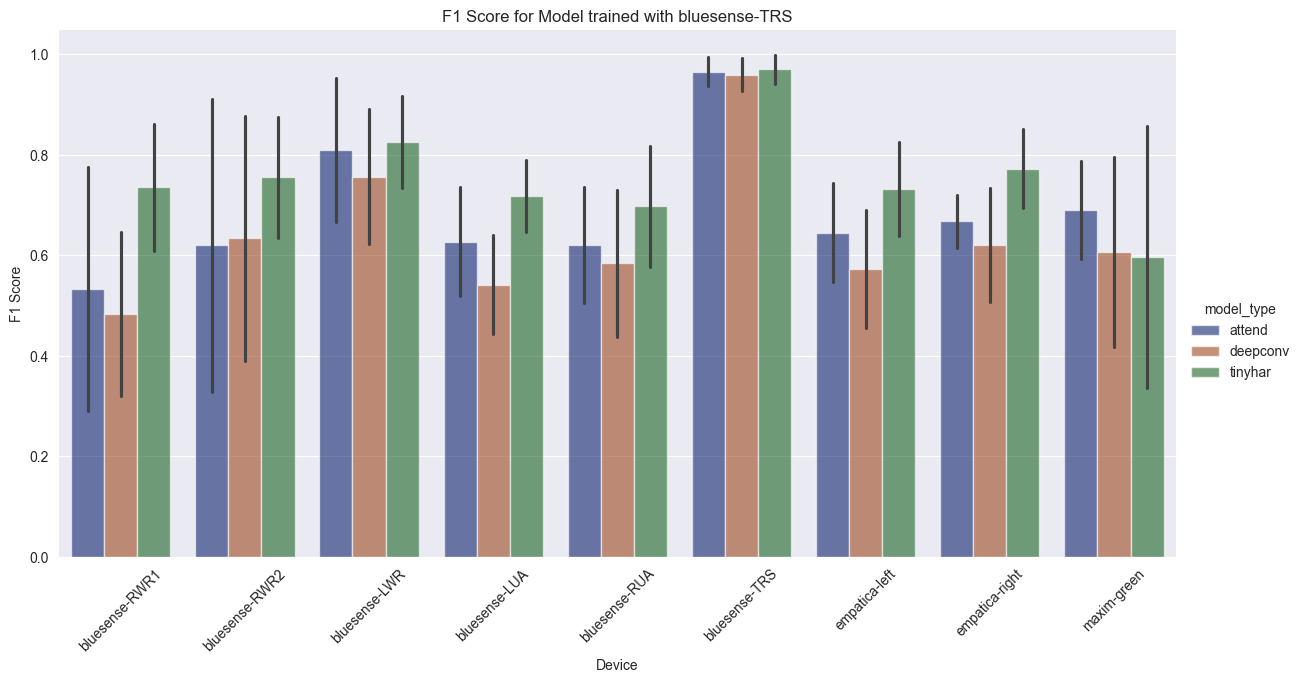

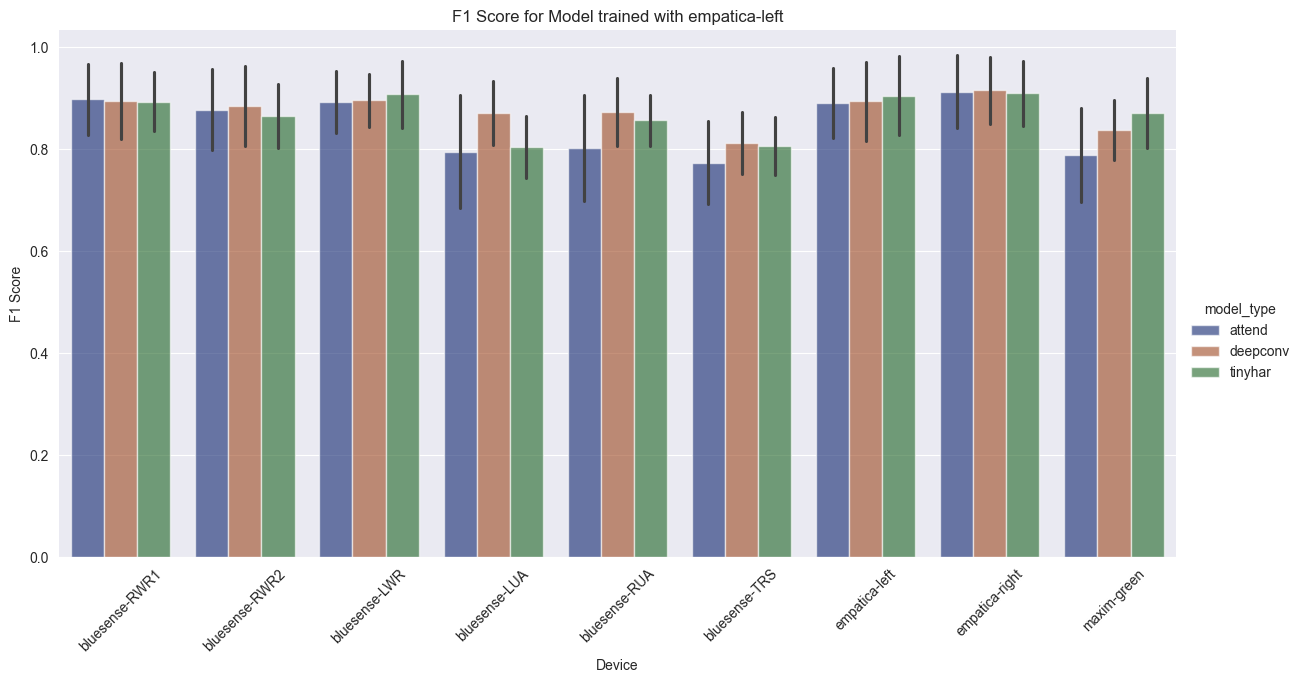

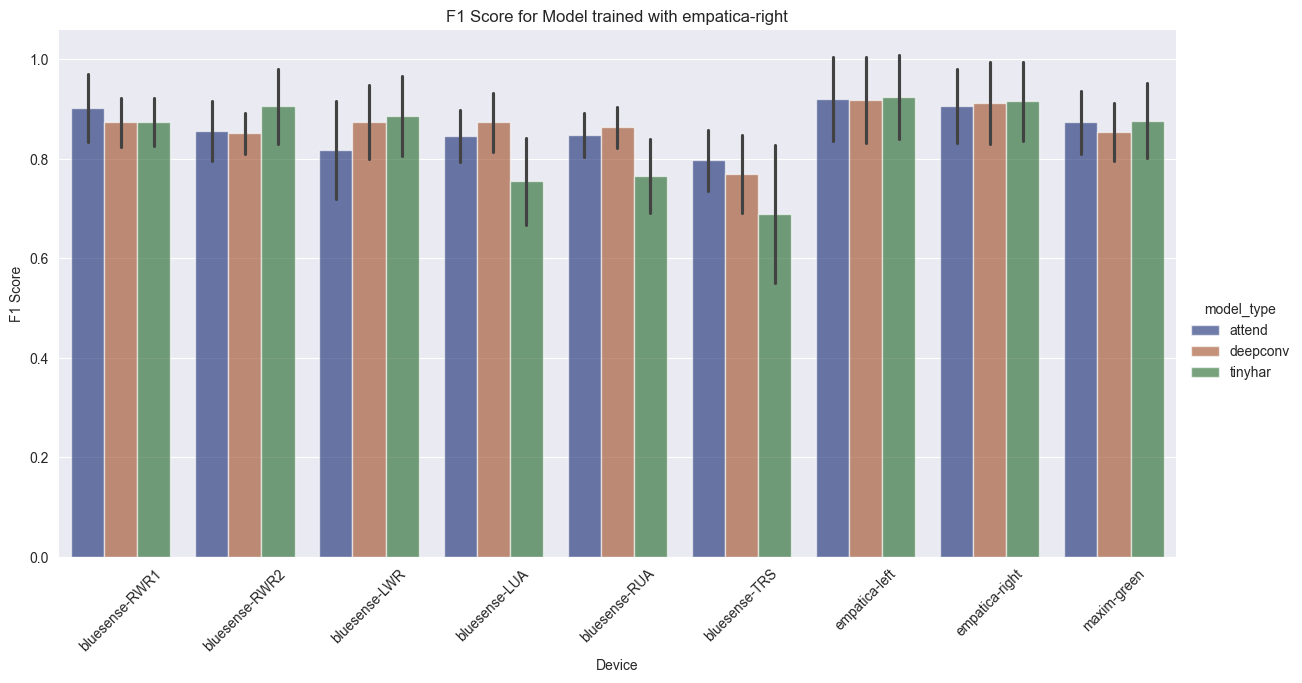

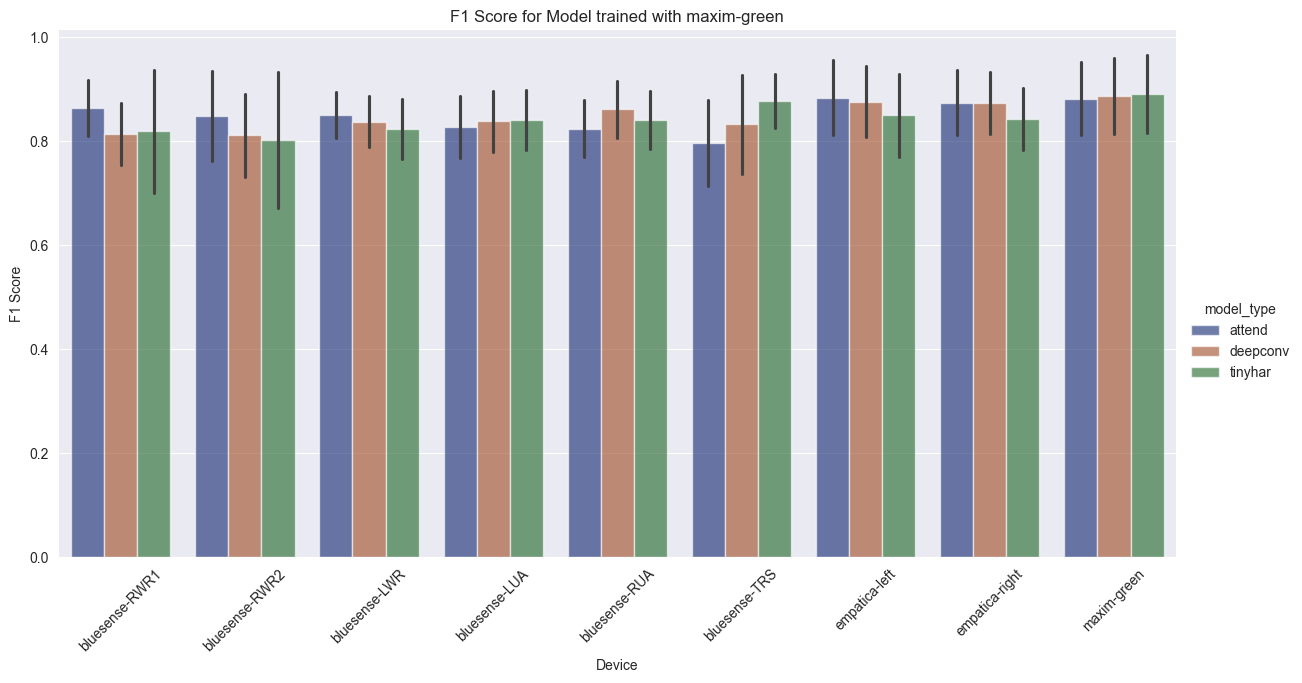

In [13]:
generate_graph_with_std(root_path, 'bluesense-RWR1', test_devices)
generate_graph_with_std(root_path, 'bluesense-RWR2', test_devices)
generate_graph_with_std(root_path, 'bluesense-LWR', test_devices)
generate_graph_with_std(root_path, 'bluesense-LUA', test_devices)
generate_graph_with_std(root_path, 'bluesense-RUA', test_devices)
generate_graph_with_std(root_path, 'bluesense-TRS', test_devices)
generate_graph_with_std(root_path, 'empatica-left', test_devices)
generate_graph_with_std(root_path, 'empatica-right', test_devices)
generate_graph_with_std(root_path, 'maxim-green', test_devices)
